In [1]:
import psycopg2
import configparser
import pandas as pd
import numpy as np
import pandas as pd
import yfinance as yf
import pandas as pd
from datetime import *
from matplotlib.pyplot import *

In [2]:
def create_connection():
    conn = psycopg2.connect("host=127.0.0.1 dbname=dmqldb user=postgres password=student")
    cur = conn.cursor()       
    return conn, cur

conn, cur = create_connection()

In [3]:
cur.execute("""select open, date, symbol 
                    from stock_history 
                    where symbol = 'AAPL' 
                    and date >= to_date('20210703', 'yyyymmdd')
                    order by date desc""")
result = cur.fetchall()
df = pd.DataFrame(result, columns = ['Open', 'Date', 'Symbol'])

cur.execute("select * from means where symbol = 'AAPL'")
result = cur.fetchall()
df_mean = pd.DataFrame(result)

cur.execute("select * from standard_deviation where symbol = 'AAPL'")
result = cur.fetchall()
df_std = pd.DataFrame(result)

In [4]:
val_lst = df_mean.values.tolist()[0]
target_mean = val_lst[-1]

mean_list = []
for i in range(1, len(val_lst)-1):
    mean_list.append(val_lst[i])
    

    
val_lst = df_std.values.tolist()[0]
target_std = val_lst[-1]

std_list = []
for i in range(1, len(val_lst)-1):
    std_list.append(val_lst[i])

In [5]:
df = df.sort_values(by='Date', ascending=True)
df.index = range(len(df))

In [6]:
# Finding missing values
t1 = df.Date[0]
t2 = df.Date.iloc[-1]
df_all = pd.DataFrame({'Date': [(t1+timedelta(days=_)) for _ in range((t2-t1).days+1)]})

df = df_all.merge(df, on='Date', how='left')
df = df.ffill()

In [7]:
# Creating Lagged Features
df = pd.concat([df.Date.shift(-60), df.Open]+[df.Open.shift(-_) for _ in range(1, 61)], axis=1)
df.columns = ['Date'] + ['Open_{}'.format(_) for _ in range(len(df.columns)-1)]
df.rename(columns={'Open_60': 'target_price'}, inplace=True)
df = df.dropna(axis=0)

In [8]:
df

,Date,Open_0,Open_1,Open_2,Open_3,Open_4,Open_5,Open_6,Open_7,Open_8,...,Open_51,Open_52,Open_53,Open_54,Open_55,Open_56,Open_57,Open_58,Open_59,target_price
0,2021-09-04,139.656634,143.116382,141.162171,142.328727,142.328727,142.328727,145.778507,143.604941,147.662935,...,148.133814,147.265075,147.265075,147.265075,148.782860,152.437526,152.607276,153.645752,153.535913,153.535913
1,2021-09-05,143.116382,141.162171,142.328727,142.328727,142.328727,145.778507,143.604941,147.662935,148.799576,...,147.265075,147.265075,147.265075,148.782860,152.437526,152.607276,153.645752,153.535913,153.535913,153.535913
2,2021-09-06,141.162171,142.328727,142.328727,142.328727,145.778507,143.604941,147.662935,148.799576,148.021876,...,147.265075,147.265075,148.782860,152.437526,152.607276,153.645752,153.535913,153.535913,153.535913,153.535913
3,2021-09-07,142.328727,142.328727,142.328727,145.778507,143.604941,147.662935,148.799576,148.021876,148.021876,...,147.265075,148.782860,152.437526,152.607276,153.645752,153.535913,153.535913,153.535913,153.535913,154.744160
4,2021-09-08,142.328727,142.328727,145.778507,143.604941,147.662935,148.799576,148.021876,148.021876,148.021876,...,148.782860,152.437526,152.607276,153.645752,153.535913,153.535913,153.535913,153.535913,154.744160,156.751227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,2021-11-29,143.450649,141.693201,141.693201,141.693201,141.553402,139.286724,139.266749,142.851516,143.820100,...,157.649994,157.649994,161.679993,161.119995,160.750000,160.750000,159.570007,159.570007,159.570007,159.369995
87,2021-11-30,141.693201,141.693201,141.693201,141.553402,139.286724,139.266749,142.851516,143.820100,143.820100,...,157.649994,161.679993,161.119995,160.750000,160.750000,159.570007,159.570007,159.570007,159.369995,159.990005
88,2021-12-01,141.693201,141.693201,141.553402,139.286724,139.266749,142.851516,143.820100,143.820100,143.820100,...,161.679993,161.119995,160.750000,160.750000,159.570007,159.570007,159.570007,159.369995,159.990005,167.479996
89,2021-12-02,141.693201,141.553402,139.286724,139.266749,142.851516,143.820100,143.820100,143.820100,142.062677,...,161.119995,160.750000,160.750000,159.570007,159.570007,159.570007,159.369995,159.990005,167.479996,158.740005


In [9]:
X_test = df[[_ for _ in df.columns if 'Open_' in _]]
y_test =  df.target_price


In [10]:
X_test.head()

,Open_0,Open_1,Open_2,Open_3,Open_4,Open_5,Open_6,Open_7,Open_8,Open_9,...,Open_50,Open_51,Open_52,Open_53,Open_54,Open_55,Open_56,Open_57,Open_58,Open_59
0,139.656634,143.116382,141.162171,142.328727,142.328727,142.328727,145.778507,143.604941,147.662935,148.799576,...,149.591667,148.133814,147.265075,147.265075,147.265075,148.782860,152.437526,152.607276,153.645752,153.535913
1,143.116382,141.162171,142.328727,142.328727,142.328727,145.778507,143.604941,147.662935,148.799576,148.021876,...,148.133814,147.265075,147.265075,147.265075,148.782860,152.437526,152.607276,153.645752,153.535913,153.535913
2,141.162171,142.328727,142.328727,142.328727,145.778507,143.604941,147.662935,148.799576,148.021876,148.021876,...,147.265075,147.265075,147.265075,148.782860,152.437526,152.607276,153.645752,153.535913,153.535913,153.535913
3,142.328727,142.328727,142.328727,145.778507,143.604941,147.662935,148.799576,148.021876,148.021876,148.021876,...,147.265075,147.265075,148.782860,152.437526,152.607276,153.645752,153.535913,153.535913,153.535913,153.535913
4,142.328727,142.328727,145.778507,143.604941,147.662935,148.799576,148.021876,148.021876,148.021876,143.325769,...,147.265075,148.782860,152.437526,152.607276,153.645752,153.535913,153.535913,153.535913,153.535913,154.744160


In [11]:
# Scale Data
for _ , col_ in enumerate(X_test.columns):
    X_test[col_+'scaled'] = X_test[col_].apply(lambda x: (x - mean_list[_])/std_list[_])

y_test_scaled = y_test.apply(lambda x: (x - target_mean)/target_std)

<ipython-input-11-0ed658e661f5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col_+'scaled'] = X_test[col_].apply(lambda x: (x - mean_list[_])/std_list[_])


In [12]:
X_test.head()

,Open_0,Open_1,Open_2,Open_3,Open_4,Open_5,Open_6,Open_7,Open_8,Open_9,...,Open_50scaled,Open_51scaled,Open_52scaled,Open_53scaled,Open_54scaled,Open_55scaled,Open_56scaled,Open_57scaled,Open_58scaled,Open_59scaled
0,139.656634,143.116382,141.162171,142.328727,142.328727,142.328727,145.778507,143.604941,147.662935,148.799576,...,4.253774,4.200363,4.166464,4.161216,4.155959,4.200795,4.315875,4.316245,4.345126,4.336192
1,143.116382,141.162171,142.328727,142.328727,142.328727,145.778507,143.604941,147.662935,148.799576,148.021876,...,4.205521,4.171641,4.166464,4.161216,4.205975,4.321098,4.321456,4.350356,4.341522,4.336192
2,141.162171,142.328727,142.328727,142.328727,145.778507,143.604941,147.662935,148.799576,148.021876,148.021876,...,4.176767,4.171641,4.166464,4.211288,4.326409,4.326686,4.355604,4.346748,4.341522,4.336192
3,142.328727,142.328727,142.328727,145.778507,143.604941,147.662935,148.799576,148.021876,148.021876,148.021876,...,4.176767,4.171641,4.216591,4.331856,4.332003,4.360870,4.351992,4.346748,4.341522,4.336192
4,142.328727,142.328727,145.778507,143.604941,147.662935,148.799576,148.021876,148.021876,148.021876,143.325769,...,4.176767,4.221823,4.337293,4.337456,4.366224,4.357254,4.351992,4.346748,4.341522,4.375794


In [13]:
# Prepare X-y data
X_test = X_test[[_ for _ in X_test.columns if 'scaled' in _]]

X_test = X_test.to_numpy()

y_test = y_test_scaled.to_numpy()

In [14]:
# Converting to 3-D tensor
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] , 1)

In [15]:
# Loading Saved Model
import tensorflow
model = tensorflow.keras.models.load_model('LSTM_APPLE.h5')

In [16]:
X_test

array([[[4.18320591],
        [4.29921346],
        [4.22586605],
        ...,
        [4.31624478],
        [4.34512565],
        [4.33619175]],

       [[4.30431345],
        [4.23087823],
        [4.26661593],
        ...,
        [4.35035603],
        [4.34152155],
        [4.33619175]],

       [[4.23590684],
        [4.27167058],
        [4.26661593],
        ...,
        [4.3467481 ],
        [4.34152155],
        [4.33619175]],

       ...,

       [[4.25449539],
        [4.24944739],
        [4.23953245],
        ...,
        [4.54495257],
        [4.53295267],
        [4.54773712]],

       [[4.25449539],
        [4.24455887],
        [4.16035329],
        ...,
        [4.53838268],
        [4.55329679],
        [4.79323604]],

       [[4.24960177],
        [4.1652972 ],
        [4.15965552],
        ...,
        [4.55874842],
        [4.79906248],
        [4.50676595]]])

In [17]:
# Predictions
predictions = model.predict(X_test)
predictions = [predictions[_][0] for _ in range(len(predictions))]
y_test_actual = [(_*target_std)+target_mean for _ in y_test]
y_test_predicted = [(_*target_std)+target_mean for _ in predictions]

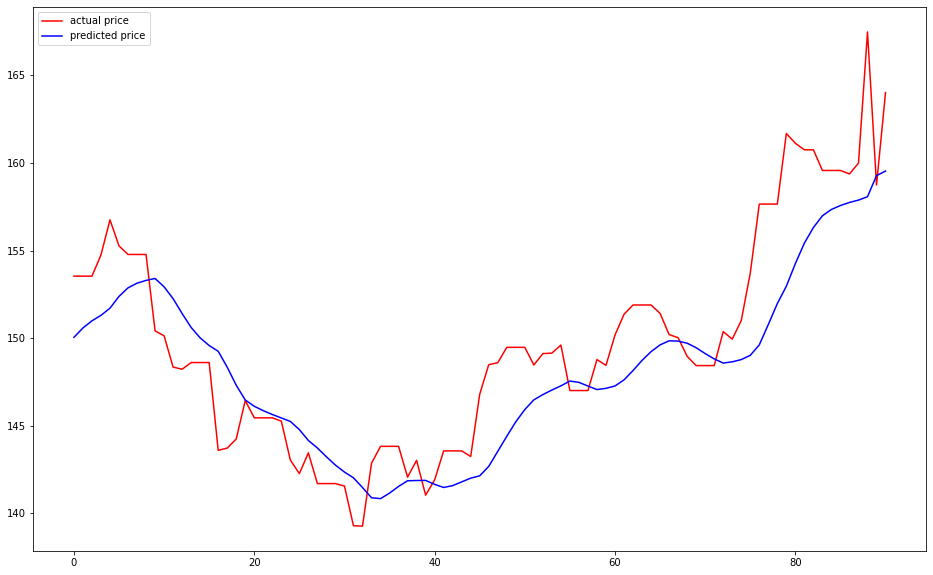

In [18]:
# Apple
figure(figsize=(16, 10))
plot(y_test_actual, color='r', label='actual price')
plot(y_test_predicted, color='b', label='predicted price')
legend()